# Evaluation pipeline

## 0 Imports and Constants

In [16]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [17]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg
from visual_evaluation import visualize
from predictive_evaluation import predictive_evaluation

In [18]:
DATA_FOLDER = Path("../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
BENCHMARK = False

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [19]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder'
syn_data_type = 'jitter'

In [20]:
# Load real time series
data_real_df = pd.read_csv(REAL_DATA_FOLDER/'metro_interstate_traffic_volume_label_encoded_no_categorical.csv')
data_real_numpy = dc(data_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_lstm_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28478_12_5_autoencoder_unscaled.csv', shape=(28478, 12, 5))

elif syn_data_type == 'jitter':
    jitter_factor = 0.1
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_jittered_{str(jitter_factor).replace(".", "")}.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

In [21]:
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_real_df.columns)
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,28511.000000,28511.000000,28511.000000,28511.000000,28511.000000
mean,3314.609915,282.697251,0.087762,0.000585,42.550345
std,1979.334229,12.438217,0.677296,0.008304,38.958564
min,0.000000,242.892694,0.000000,0.000000,0.000000
25%,1307.756109,273.430078,0.000000,0.000000,2.276123
50%,3519.132346,284.438376,0.003428,0.000000,37.938644
75%,4957.645301,292.805025,0.052643,0.000568,86.159244
max,7499.889454,310.882360,42.007573,0.510301,107.027592


In [22]:
data_real_df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,28511.00000,28511.000000,28511.000000,28511.000000,28511.000000
mean,3313.74238,282.688768,0.061611,0.000250,42.122795
std,1971.53206,12.367361,0.678185,0.008298,39.316195
min,0.00000,243.390000,0.000000,0.000000,0.000000
25%,1289.00000,273.480000,0.000000,0.000000,1.000000
50%,3507.00000,284.550000,0.000000,0.000000,40.000000
75%,4948.00000,292.790000,0.000000,0.000000,90.000000
max,7280.00000,310.070000,42.000000,0.510000,100.000000


## 2 Train and Test Baseline Model

### Set Hyperparameters and Features

In [23]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 4,
    "num_layers": 1,
    "num_evaluation_runs": 10,
    "num_epochs": 200,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [24]:
results = predictive_evaluation(data_real_numpy, data_syn_numpy, hyperparameters, include_baseline=True, verbose=True)

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  4
num_layers :  1
num_evaluation_runs :  10
num_epochs :  200
device :  cpu
Synthetic Data is sequential: False
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.5521320375800133
Training Loss: 0.4500365850329399
Training Loss: 0.35785618633031846
Validation Loss: 0.22566637028469128
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.20727982167154552
Training Loss: 0.14357522808015347
Training Loss: 0.11016296058893203
Validation Loss: 0.0763319128852212
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.08103626372292638
Training Loss: 0.07519765118137002
Training Loss: 0.07341821977868676
Validation Loss: 0.06599259179797065
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06865114687010646
Training Loss: 0.06850901484489441
Training Loss: 0.06827586220577359
Validation Loss: 0.06276435798473573
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.06425764945335687
Training Loss: 0.06377812531776726
Training Loss: 0

c:\Users\fanny\Documents\ArnesShit\time_series_data_augmentation\data_evaluation\predictive_evaluation.py:255: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [02:31<22:39, 151.07s/it]

Validation Loss: 0.00321870066586547
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.09658761993050576
Training Loss: 0.08031178018078208
Training Loss: 0.07402516283094883
Validation Loss: 0.06814003727409278
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06863283475860954
Training Loss: 0.06777406817302108
Training Loss: 0.06681125290691853
Validation Loss: 0.06310274054327708
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06353999324142932
Training Loss: 0.06244449030607939
Training Loss: 0.06089218690991402
Validation Loss: 0.05644018064891355
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.056569183208048344
Training Loss: 0.05465948013588786
Training Loss: 0.05232197614386678
Validation Loss: 0.04708953436171071
Validation Accuracy: 0.0
*****************************

 20%|██        | 2/10 [05:02<20:08, 151.07s/it]

Training Loss: 0.0057360784168122335
Validation Loss: 0.003155435617291107
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.08412747969850898
Training Loss: 0.07487512188032269
Training Loss: 0.07221389051526785
Validation Loss: 0.06563495606016577
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06717987544834614
Training Loss: 0.06644755318760871
Training Loss: 0.06575750015676021
Validation Loss: 0.05922129067979502
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06124685214832425
Training Loss: 0.06007185539230704
Training Loss: 0.05878416320309043
Validation Loss: 0.051334404041258136
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.053227047761902214
Training Loss: 0.05120619846507907
Training Loss: 0.04919970951974392
Validation Loss: 0.04174463750187601
Validation Accu

 30%|███       | 3/10 [07:32<17:35, 150.82s/it]

Training Loss: 0.005019438926829025
Validation Loss: 0.0025486233003249163
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07858436740934849
Training Loss: 0.07201367937028408
Training Loss: 0.06891362505033612
Validation Loss: 0.062339771706401634
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06363692801445722
Training Loss: 0.06200914217159152
Training Loss: 0.05980329712852836
Validation Loss: 0.05318022933736276
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05411225249059498
Training Loss: 0.051562070082873106
Training Loss: 0.048637196756899356
Validation Loss: 0.04195287055597546
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04268436682410538
Training Loss: 0.03990974804386496
Training Loss: 0.037309535378590226
Validation Loss: 0.03169153074032805
Validation Ac

 40%|████      | 4/10 [10:03<15:04, 150.68s/it]

Training Loss: 0.005027661338681355
Validation Loss: 0.0026126508103955664
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3427133320271969
Training Loss: 0.2556185609102249
Training Loss: 0.19207063373178243
Validation Loss: 0.13518705729688152
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.12381840623915195
Training Loss: 0.10214487995952368
Training Loss: 0.09243503592908382
Validation Loss: 0.08587341462628226
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.08480286940932275
Training Loss: 0.08360745238140226
Training Loss: 0.08251411160454154
Validation Loss: 0.08000405396470862
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.07875292597338557
Training Loss: 0.07789763139560818
Training Loss: 0.0768245223723352
Validation Loss: 0.0740033933955632
Validation Accuracy: 

 50%|█████     | 5/10 [12:34<12:34, 150.85s/it]

Training Loss: 0.005472571206628345
Validation Loss: 0.0029294641016134886
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.7189407405257225
Training Loss: 0.6143703299760819
Training Loss: 0.5078303414583206
Validation Loss: 0.37199543902043547
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.3145623592287302
Training Loss: 0.21076797895133495
Training Loss: 0.1429582539573312
Validation Loss: 0.09405989836106139
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.08637635296210647
Training Loss: 0.07292447550222278
Training Loss: 0.06781622197479009
Validation Loss: 0.06121627249744501
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06275764927268028
Training Loss: 0.06276895569637418
Training Loss: 0.06283809814602137
Validation Loss: 0.05911472322565786
Validation Accuracy: 0

 60%|██████    | 6/10 [15:04<10:03, 150.78s/it]

Training Loss: 0.006575218753423542
Validation Loss: 0.00395014404784888
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.10739677529782057
Training Loss: 0.09069374470040202
Training Loss: 0.07869932986795902
Validation Loss: 0.0680212223630273
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06706428792327643
Training Loss: 0.06590791145339608
Training Loss: 0.06525563983246684
Validation Loss: 0.06107131203406312
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06225955419242382
Training Loss: 0.06146451260894537
Training Loss: 0.06049423540011048
Validation Loss: 0.05622601237022475
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05717246325686574
Training Loss: 0.05585582533851266
Training Loss: 0.05439279362559318
Validation Loss: 0.04992615820819073
Validation Accuracy:

 70%|███████   | 7/10 [17:35<07:32, 150.84s/it]

Training Loss: 0.004802062826929614
Validation Loss: 0.0024079160550295304
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.41966582417488096
Training Loss: 0.35058857418596745
Training Loss: 0.29117364950478075
Validation Loss: 0.1996717191814037
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.18020024243742228
Training Loss: 0.12049757219851016
Training Loss: 0.09200996337458492
Validation Loss: 0.07440277117859112
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07793560709804297
Training Loss: 0.07667856317013502
Training Loss: 0.07593371042981743
Validation Loss: 0.0700097649954678
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.07199015267193318
Training Loss: 0.07140544408932328
Training Loss: 0.07077793696895242
Validation Loss: 0.0650583789422271
Validation Accuracy:

 80%|████████  | 8/10 [20:06<05:01, 150.73s/it]

Training Loss: 0.005805516363470815
Validation Loss: 0.003358245386449055
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.8077603486180306
Training Loss: 0.6606598161160946
Training Loss: 0.5247499960660934
Validation Loss: 0.3596809474604853
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.3087680798768997
Training Loss: 0.19584496472030877
Training Loss: 0.12936291567981242
Validation Loss: 0.08249010744222095
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.08206522895023227
Training Loss: 0.07456390470266343
Training Loss: 0.07278195280581713
Validation Loss: 0.064357882177227
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06850168075412512
Training Loss: 0.06920991517603398
Training Loss: 0.06942361272871495
Validation Loss: 0.062482595025153645
Validation Accuracy: 0.0

 90%|█████████ | 9/10 [22:36<02:30, 150.70s/it]

Training Loss: 0.005726748197339475
Validation Loss: 0.0031022206982179138
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.4474074551463127
Training Loss: 0.34777912192046645
Training Loss: 0.2447179251909256
Validation Loss: 0.13602800474742824
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.11016623761504889
Training Loss: 0.08046676073223352
Training Loss: 0.07412771591916681
Validation Loss: 0.0668835434434789
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06915545275434852
Training Loss: 0.06931339971721172
Training Loss: 0.06928157145157457
Validation Loss: 0.06388099010238486
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06558118689805269
Training Loss: 0.06547983398661017
Training Loss: 0.06514015294611454
Validation Loss: 0.06022429960162452
Validation Accuracy:

100%|██████████| 10/10 [25:08<00:00, 150.86s/it]

Training Loss: 0.006042901771143079
Validation Loss: 0.0034531505668556756
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)


Shape of the data after splitting into sequences: (28500, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.527780042886734
Training Loss: 0.4406342294812202
Training Loss: 0.3525332354754209
Validation Loss: 0.25925375625825997
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.2082717040926218
Training Loss: 0.1294027565047145
Training Loss: 0.09041277589276434
Validation Loss: 0.07708330986121398
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07318253699690104
Training Loss: 0.06918315690010786
Training Loss: 0.06848396083340048
Validation Loss: 0.06879869921739852
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06815459558740258
Training Loss: 0.06585992977023125
Training Loss: 0.06499405948445201
Validation Loss: 0.0649461592181345
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.06418027767911554
Training Loss: 0.06164193958044052
Training Loss: 0.060

 10%|█         | 1/10 [02:35<23:22, 155.81s/it]

Training Loss: 0.005210543618304655
Validation Loss: 0.0034217253749865744
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.4111085778474808
Training Loss: 0.33355422407388685
Training Loss: 0.24585677452385427
Validation Loss: 0.14990679775312377
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.11490037458017469
Training Loss: 0.07371145309880375
Training Loss: 0.06451186621561647
Validation Loss: 0.06387939620135205
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06251219097524881
Training Loss: 0.05949104825034737
Training Loss: 0.05802638996392488
Validation Loss: 0.05785227876700712
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05636348186060786
Training Loss: 0.053189888997003436
Training Loss: 0.051199394762516025
Validation Loss: 0.050856741930075576
Validation Accu

 20%|██        | 2/10 [05:11<20:44, 155.59s/it]

Training Loss: 0.005799228476826101
Validation Loss: 0.003935294964199028
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.8737330201268196
Training Loss: 0.6483163394033908
Training Loss: 0.4337647503614426
Validation Loss: 0.23632426245996122
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.17144425116479398
Training Loss: 0.09039131388068199
Training Loss: 0.06908112406730652
Validation Loss: 0.06549013745081558
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06408564979210496
Training Loss: 0.06102075358852744
Training Loss: 0.05947609059512615
Validation Loss: 0.059029754753528015
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0574801230430603
Training Loss: 0.054453493393957615
Training Loss: 0.0523752335831523
Validation Loss: 0.051870023130617116
Validation Accuracy:

 30%|███       | 3/10 [07:47<18:10, 155.78s/it]

Training Loss: 0.006307574636884965
Validation Loss: 0.004348457826228206
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.45002232044935225
Training Loss: 0.36459931716322896
Training Loss: 0.291213800534606
Validation Loss: 0.23297072109881412
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.20058846700936556
Training Loss: 0.14581985648721457
Training Loss: 0.1094549199193716
Validation Loss: 0.08937574322387744
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.08073346503078938
Training Loss: 0.06986771734431386
Training Loss: 0.06668979920446873
Validation Loss: 0.06670313820326595
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06593587826937437
Training Loss: 0.06374122178182005
Training Loss: 0.06318891543895006
Validation Loss: 0.06326365529486302
Validation Accuracy: 

 40%|████      | 4/10 [10:21<15:30, 155.00s/it]

Training Loss: 0.005167034551559482
Validation Loss: 0.003220455083352503
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.6048874482512474
Training Loss: 0.5269002915918827
Training Loss: 0.45123921558260915
Validation Loss: 0.37488507764058165
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.3346602816879749
Training Loss: 0.2508139880001545
Training Loss: 0.1853283302485943
Validation Loss: 0.14091514170253544
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.1236425793543458
Training Loss: 0.09548830352723599
Training Loss: 0.07995226563885809
Validation Loss: 0.07336226509611928
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06981799507513642
Training Loss: 0.0641472278535366
Training Loss: 0.061883536148816344
Validation Loss: 0.06210045518583796
Validation Accuracy: 0.0

 50%|█████     | 5/10 [12:49<12:42, 152.53s/it]

Training Loss: 0.005553593265940435
Validation Loss: 0.003748532579531579
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.40479973927140234
Training Loss: 0.34911960534751413
Training Loss: 0.2974344905465841
Validation Loss: 0.23522366784261853
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.19791626647114755
Training Loss: 0.13177838638424874
Training Loss: 0.09662434292957187
Validation Loss: 0.08256278969766048
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07701819146052002
Training Loss: 0.06956214524805546
Training Loss: 0.06706185832619667
Validation Loss: 0.0678766333613168
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06640594029799103
Training Loss: 0.0640949211269617
Training Loss: 0.06303202982991934
Validation Loss: 0.06379024148657081
Validation Accuracy: 

 60%|██████    | 6/10 [15:16<10:03, 150.90s/it]

Training Loss: 0.005813752188696526
Validation Loss: 0.0039917528786267455
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.0819719933718443
Training Loss: 0.07437907328829169
Training Loss: 0.07108328295871616
Validation Loss: 0.07018689557993679
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06846898131072521
Training Loss: 0.06563308909535408
Training Loss: 0.06359197864308953
Validation Loss: 0.06276511084916217
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.061454639211297034
Training Loss: 0.058650835445150734
Training Loss: 0.05612019138410687
Validation Loss: 0.054273559387480276
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05317695923149586
Training Loss: 0.050103281382471325
Training Loss: 0.04685492817312479
Validation Loss: 0.04412878986992193
Validation Acc

 70%|███████   | 7/10 [17:44<07:29, 149.83s/it]

Validation Loss: 0.0026862728612214912
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.0756915850751102
Training Loss: 0.07332164742052555
Training Loss: 0.07228668110445141
Validation Loss: 0.07254908895224668
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07173549761995673
Training Loss: 0.06929223340004682
Training Loss: 0.06792311847209931
Validation Loss: 0.06752153257891703
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0663650020584464
Training Loss: 0.06294372208416461
Training Loss: 0.06030748184770346
Validation Loss: 0.05825424688250831
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.056510394420474765
Training Loss: 0.05171666641719639
Training Loss: 0.0475356507115066
Validation Loss: 0.04395019669043884
Validation Accuracy: 0.0
******************************

 80%|████████  | 8/10 [20:12<04:58, 149.22s/it]

Training Loss: 0.0054931094212224705
Validation Loss: 0.0036588481161743402
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.13150465864688157
Training Loss: 0.10718462876975536
Training Loss: 0.09323472745716571
Validation Loss: 0.08598459892895784
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08413754904642701
Training Loss: 0.07942399507388473
Training Loss: 0.0770998626947403
Validation Loss: 0.07599474929189415
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07529293091967702
Training Loss: 0.07266986768692732
Training Loss: 0.07148431835696101
Validation Loss: 0.07112480427944258
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.07066534858196974
Training Loss: 0.0685205659456551
Training Loss: 0.06769059110432864
Validation Loss: 0.06748923862332039
Validation Accurac

 90%|█████████ | 9/10 [22:40<02:28, 148.82s/it]

Training Loss: 0.0049961046763928605
Validation Loss: 0.0031277158551357605
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07479558972641825
Training Loss: 0.07219511402770877
Training Loss: 0.07090478278696537
Validation Loss: 0.07143728688275547
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06996932653710246
Training Loss: 0.0674730233848095
Training Loss: 0.06491521185263992
Validation Loss: 0.0626480599467674
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06030364736914635
Training Loss: 0.05529378335922956
Training Loss: 0.05050751239061355
Validation Loss: 0.04630573367009337
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0448916787840426
Training Loss: 0.03992381458170712
Training Loss: 0.0352806421648711
Validation Loss: 0.030764714919365523
Validation Accuracy

100%|██████████| 10/10 [25:08<00:00, 150.84s/it]


Validation Loss: 0.002697346647651971
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)
Shape of the data after splitting into sequences: (28500, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.8156773480772972
Training Loss: 0.6427613791823387
Training Loss: 0.5004396986961365
Validation Loss: 0.35722908980391
Validation Accuracy: 0.5442415730337079
**************************************************
Epoch: 2
Training Loss: 0.29547644056379796
Training Loss: 0.20034219183027743
Training Loss: 0.1349733803421259
Validation Loss: 0.09009511323038781
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0779067107848823
Training Loss: 0.06512088788673281
Training Loss: 0.06009992368519306
Validation Loss: 0.05818530084209496
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05734185332432389
Training Loss: 0.05515352001413703
Training Loss: 0.05321700341999531
Validation Loss: 0.052350302007091176
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.05137481041252613
Training Loss: 0.04897444006986916
Train

 10%|█         | 1/10 [02:28<22:12, 148.06s/it]

Training Loss: 0.0065441158751491455
Validation Loss: 0.004259731472087919
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.11953692913055419
Training Loss: 0.1010743436217308
Training Loss: 0.08597028397023677
Validation Loss: 0.07205619093742263
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06637419365346432
Training Loss: 0.06011049525812268
Training Loss: 0.05612170178443193
Validation Loss: 0.05321463693477464
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05175934435799718
Training Loss: 0.04780995709821582
Training Loss: 0.0442838122881949
Validation Loss: 0.04113217464156365
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0399712781328708
Training Loss: 0.03622826224192977
Training Loss: 0.03321001091971994
Validation Loss: 0.030002664790352743
Validation Accuracy

 20%|██        | 2/10 [04:55<19:43, 147.97s/it]

Training Loss: 0.007098422080744058
Validation Loss: 0.004749640777937315
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.08001736253499984
Training Loss: 0.06915318988263607
Training Loss: 0.06256739672273398
Validation Loss: 0.0583932651311494
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05675311826169491
Training Loss: 0.05270977344363928
Training Loss: 0.04900620253756642
Validation Loss: 0.04670684087728517
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04512997002340853
Training Loss: 0.041393864210695026
Training Loss: 0.03829712161794305
Validation Loss: 0.0361556591141676
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.034669252978637814
Training Loss: 0.031303512370213865
Training Loss: 0.02883251248858869
Validation Loss: 0.026610768049578654
Validation Accur

 30%|███       | 3/10 [07:23<17:14, 147.85s/it]

Training Loss: 0.006623618976445869
Validation Loss: 0.004342867470911464
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.2152504277601838
Training Loss: 0.1569312209263444
Training Loss: 0.1230244160629809
Validation Loss: 0.09902593150232615
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08909749623388052
Training Loss: 0.0804352474398911
Training Loss: 0.07665874149650335
Validation Loss: 0.07550015712805679
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07423323292285204
Training Loss: 0.07262357987463475
Training Loss: 0.07156724471598863
Validation Loss: 0.07170326520134224
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.07101041300222277
Training Loss: 0.06952043075114489
Training Loss: 0.06852234950289131
Validation Loss: 0.06857615663261896
Validation Accuracy: 0

 40%|████      | 4/10 [09:51<14:47, 147.84s/it]

Validation Loss: 0.004674696296798798
Validation Accuracy: 0.05266853932584269
**************************************************
Epoch: 1
Training Loss: 0.07484477354213595
Training Loss: 0.07155817860737443
Training Loss: 0.0689566183462739
Validation Loss: 0.0679061274682538
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06662943916395307
Training Loss: 0.06400461327284575
Training Loss: 0.061851162128150464
Validation Loss: 0.06038019824982359
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.059263686332851645
Training Loss: 0.05649226764217019
Training Loss: 0.054268747474998234
Validation Loss: 0.05220033981826868
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05128563843667507
Training Loss: 0.04842355522327125
Training Loss: 0.046149573456496
Validation Loss: 0.043647680243247014
Validation Accuracy: 0.0
*************

 50%|█████     | 5/10 [12:19<12:19, 147.82s/it]

Training Loss: 0.007770784315653145
Validation Loss: 0.005505418976549101
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 1.0002240473031998
Training Loss: 0.8522652235627174
Training Loss: 0.7307652314007282
Validation Loss: 0.5709116078829497
Validation Accuracy: 0.5442415730337079
**************************************************
Epoch: 2
Training Loss: 0.46401362389326095
Training Loss: 0.274301274381578
Training Loss: 0.13017958341166377
Validation Loss: 0.07572540065294571
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06876192124560475
Training Loss: 0.06344868117943406
Training Loss: 0.06012093974277377
Validation Loss: 0.059121205021491215
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.056453688740730285
Training Loss: 0.053046414274722335
Training Loss: 0.050149201452732085
Validation Loss: 0.048788323224093134
Vali

 60%|██████    | 6/10 [14:47<09:51, 147.97s/it]

Training Loss: 0.007133847705554217
Validation Loss: 0.004838714901922962
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07344634626060724
Training Loss: 0.06651218947023153
Training Loss: 0.06401774564757944
Validation Loss: 0.0630619880858432
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.062366934064775705
Training Loss: 0.06018328733742237
Training Loss: 0.05823693642392755
Validation Loss: 0.056827539306008416
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05577429526485503
Training Loss: 0.05264188252389431
Training Loss: 0.04946924649178982
Validation Loss: 0.04651995306688078
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04494273548945785
Training Loss: 0.040588378002867104
Training Loss: 0.03654654124751687
Validation Loss: 0.03233257731883211
Validation Accur

 70%|███████   | 7/10 [17:15<07:24, 148.06s/it]

Training Loss: 0.007029145230771974
Validation Loss: 0.00475107046534841
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.6798785389959812
Training Loss: 0.604961868673563
Training Loss: 0.5360102474689483
Validation Loss: 0.4409030540270752
Validation Accuracy: 0.5442415730337079
**************************************************
Epoch: 2
Training Loss: 0.3892568515986204
Training Loss: 0.2981566652655602
Training Loss: 0.1984592751413584
Validation Loss: 0.10822134881458256
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.08874802768230439
Training Loss: 0.07046282006427645
Training Loss: 0.06480019565671682
Validation Loss: 0.06365002202016584
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0625052665360272
Training Loss: 0.06069034861400723
Training Loss: 0.05890907131135464
Validation Loss: 0.058454252737626604
Validation A

 80%|████████  | 8/10 [19:43<04:56, 148.03s/it]

Validation Loss: 0.005111378490705085
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.14876488994807005
Training Loss: 0.10600458825007081
Training Loss: 0.07460961313918232
Validation Loss: 0.057474783883335885
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.054697492932900785
Training Loss: 0.05180074276402593
Training Loss: 0.05028439523652196
Validation Loss: 0.04978636605141873
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.049136332208290695
Training Loss: 0.04689816449768841
Training Loss: 0.045243909154087304
Validation Loss: 0.0443980877047007
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.043843934498727324
Training Loss: 0.04151494322344661
Training Loss: 0.03984220564365387
Validation Loss: 0.03871666606557503
Validation Accuracy: 0.0
*************************

 90%|█████████ | 9/10 [22:11<02:28, 148.08s/it]

Training Loss: 0.007240878506563604
Validation Loss: 0.004984873020629074
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07748712856322527
Training Loss: 0.07041946850717068
Training Loss: 0.06605850579217076
Validation Loss: 0.06498553386230148
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06287463679909706
Training Loss: 0.060105094891041516
Training Loss: 0.056375578120350836
Validation Loss: 0.05478071858792492
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.052748915813863276
Training Loss: 0.04944891856983304
Training Loss: 0.04547012354247272
Validation Loss: 0.04348119793020273
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04190001375041902
Training Loss: 0.03879361533559859
Training Loss: 0.03562024561688304
Validation Loss: 0.03394435704005568
Validation Accu

100%|██████████| 10/10 [24:39<00:00, 148.00s/it]

Training Loss: 0.006670341732678935
Validation Loss: 0.004446476663912783
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.056786455828696486
Training Loss: 0.053125640116631984
Training Loss: 0.05057024510577321
Training Loss: 0.048582135215401646
Training Loss: 0.045119447531178594
Training Loss: 0.04271987894549966
Training Loss: 0.03864480452612042
Validation Loss: 0.03703280087658082
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.035030191158875824
Training Loss: 0.03142258777283132
Training Loss: 0.028378105838783085
Training Loss: 0.026406987397931517
Training Loss: 0.02334502595011145
Training Loss: 0.02125405676662922
Training Loss: 0.019569223050493748
Validation Loss: 0.018334155584849444
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.01848749226424843
Training Loss: 0.01720594002166763
Training Loss: 0.016858201045542955
Training Loss: 0.017120526100043207
Training Loss: 0.016920884114224464
Training Loss: 0.01654966826317832
Training Loss: 0.016067515378817916

 10%|█         | 1/10 [04:50<43:33, 290.42s/it]

Validation Loss: 0.0031931716063642378
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5862308865785599
Training Loss: 0.46895305812358856
Training Loss: 0.3622805516421795
Training Loss: 0.24134528383612633
Training Loss: 0.1425418009608984
Training Loss: 0.08753643760457636
Training Loss: 0.07262229058891535
Validation Loss: 0.06901516650946399
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06882957268506289
Training Loss: 0.06638377822935582
Training Loss: 0.06547016635537148
Training Loss: 0.06494133757427335
Training Loss: 0.06261815577745437
Training Loss: 0.06250960256904364
Training Loss: 0.06028001418337226
Validation Loss: 0.05856702857640352
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05848550038412213
Training Loss: 0.0559947319701314
Training Loss: 0.05466791328042746
Training Loss: 0.05392538316547871
Traini

 20%|██        | 2/10 [09:41<38:45, 290.71s/it]

Validation Loss: 0.004026316490882401
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3139440955221653
Training Loss: 0.23827197164297104
Training Loss: 0.16812228713184596
Training Loss: 0.11199446182698011
Training Loss: 0.08494390470907093
Training Loss: 0.07663045078516006
Training Loss: 0.07281620774418116
Validation Loss: 0.07071368082353238
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07057866474613547
Training Loss: 0.06740441827103495
Training Loss: 0.06572338245809078
Training Loss: 0.06454225111752748
Training Loss: 0.061631638072431084
Training Loss: 0.06087569991126657
Training Loss: 0.05771827567368746
Validation Loss: 0.05633845632330755
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05538824137300253
Training Loss: 0.05217781636863947
Training Loss: 0.05002515367232263
Training Loss: 0.04861506004817784
Tra

 30%|███       | 3/10 [14:32<33:55, 290.77s/it]

Training Loss: 0.006517111884895712
Validation Loss: 0.0038043923714383043
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3496429241448641
Training Loss: 0.23628470659255982
Training Loss: 0.15472014095634223
Training Loss: 0.10280798483639955
Training Loss: 0.07711144067347049
Training Loss: 0.06644655827432872
Training Loss: 0.06228389635682106
Validation Loss: 0.05912454692081789
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.060105521082878116
Training Loss: 0.057653724793344734
Training Loss: 0.05646635100245476
Training Loss: 0.05569142369553447
Training Loss: 0.05307673780247569
Training Loss: 0.05256976637989283
Training Loss: 0.04983686039224267
Validation Loss: 0.04760685220556089
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04750325556844473
Training Loss: 0.04473854023963213
Training Loss: 0.04284152553416789


 40%|████      | 4/10 [18:42<27:27, 274.64s/it]

Training Loss: 0.006615993975428864
Validation Loss: 0.00390054897295332
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 172
Early stopping after 172 epochs
Epoch: 1
Training Loss: 0.07362146044149995
Training Loss: 0.0653688457235694
Training Loss: 0.0640603168681264
Training Loss: 0.06375404492020607
Training Loss: 0.06191727327182889
Training Loss: 0.06207784572616219
Training Loss: 0.05991902019828558
Validation Loss: 0.058982931523957054
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05855969338677824
Training Loss: 0.05589630875736475
Training Loss: 0.054467774219810965
Training Loss: 0.05363731293007731
Training Loss: 0.05094945041462779
Training Loss: 0.049914721325039865
Training Loss: 0.04653417774476111
Validation Loss: 0.044564279228839536
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.043331340234726665
Training Loss: 0.0398154263291508
Trai

 50%|█████     | 5/10 [23:33<23:22, 280.51s/it]

Training Loss: 0.006491131437942385
Validation Loss: 0.0037843976758441394
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.089188864082098
Training Loss: 0.06611082479357719
Training Loss: 0.05991122655570507
Training Loss: 0.058817522656172516
Training Loss: 0.05610646761953831
Training Loss: 0.05545242195948959
Training Loss: 0.05262578463181853
Validation Loss: 0.05047118270330215
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.049921884890645744
Training Loss: 0.04699098696932197
Training Loss: 0.044450144832953814
Training Loss: 0.04289044418372214
Training Loss: 0.03944903915748
Training Loss: 0.03755229788832366
Training Loss: 0.034050758816301825
Validation Loss: 0.031139755998267217
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.030328139802441
Training Loss: 0.02731298979371786
Training Loss: 0.024442891008220613
Tr

 60%|██████    | 6/10 [28:23<18:55, 283.83s/it]

Training Loss: 0.006043774218996986
Validation Loss: 0.003258145217215189
Validation Accuracy: 0.023408239700374533
**************************************************
Epoch: 1
Training Loss: 0.11438537370413542
Training Loss: 0.07451612452045082
Training Loss: 0.05466147415339947
Training Loss: 0.04893398767337203
Training Loss: 0.046335135279223325
Training Loss: 0.04584996216930449
Training Loss: 0.043287460366263984
Validation Loss: 0.04084259106983406
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.040942498100921515
Training Loss: 0.03874189724214375
Training Loss: 0.03685160119086504
Training Loss: 0.03617169683799148
Training Loss: 0.03358718964271248
Training Loss: 0.03269900935702026
Training Loss: 0.030384849552065135
Validation Loss: 0.0281410018568126
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.028140679351054132
Training Loss: 0.026412950088270007
Training Loss: 

 70%|███████   | 7/10 [33:13<14:17, 285.94s/it]

Training Loss: 0.006808256029617041
Validation Loss: 0.004062368992318431
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.08415109494701029
Training Loss: 0.0717841755785048
Training Loss: 0.06833817457780242
Training Loss: 0.0659710925258696
Training Loss: 0.06249840592965484
Training Loss: 0.060536219999194146
Training Loss: 0.056807017792016266
Validation Loss: 0.05517768081319466
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.053591168271377686
Training Loss: 0.04888478844426572
Training Loss: 0.04582475450821221
Training Loss: 0.04360263870097697
Training Loss: 0.039988239416852596
Training Loss: 0.03755320060066879
Training Loss: 0.03397266293875873
Validation Loss: 0.032070519263099194
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0308980627451092
Training Loss: 0.027987168463878335
Training Loss: 0.02597874807193875

 80%|████████  | 8/10 [38:04<09:34, 287.38s/it]

Training Loss: 0.005673770505236462
Validation Loss: 0.003077060654576282
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.08186990931630135
Training Loss: 0.07225333360955119
Training Loss: 0.0695342435874045
Training Loss: 0.06857612252235412
Training Loss: 0.06638177376240492
Training Loss: 0.06599279431626201
Training Loss: 0.06382682843133808
Validation Loss: 0.06238908129517505
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06182435423135758
Training Loss: 0.05850298222154379
Training Loss: 0.056260238960385324
Training Loss: 0.05460201658308506
Training Loss: 0.05093302519991994
Training Loss: 0.04882427457720041
Training Loss: 0.04500012054108083
Validation Loss: 0.04244404360093874
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04126772405579686
Training Loss: 0.037757033919915556
Training Loss: 0.035019482327625154


 90%|█████████ | 9/10 [42:54<04:48, 288.37s/it]

Training Loss: 0.00659021306084469
Validation Loss: 0.0037796654257128076
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.38476585164666177
Training Loss: 0.3157054241001606
Training Loss: 0.2532561443001032
Training Loss: 0.18719807658344506
Training Loss: 0.136425850559026
Training Loss: 0.09383968364447355
Training Loss: 0.07309822315350174
Validation Loss: 0.06671758022591863
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06487504016607999
Training Loss: 0.06169808741658926
Training Loss: 0.06128638410940766
Training Loss: 0.06141716549172997
Training Loss: 0.059868228286504746
Training Loss: 0.06022033628076315
Training Loss: 0.05843422319740057
Validation Loss: 0.05639902304174302
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05689621965400875
Training Loss: 0.05443812483921647
Training Loss: 0.05290136311203241
Train

100%|██████████| 10/10 [47:45<00:00, 286.53s/it]

Training Loss: 0.006087588657974266
Validation Loss: 0.0034096938128886597
Validation Accuracy: 0.0
**************************************************


In [25]:
results.shape

(80, 3)

In [26]:
results.to_csv(DATA_FOLDER / f"results/results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}.csv", index=False)

In [27]:
mse_results = results.loc[results['Metric'] == 'MSE']
mae_results = results.loc[results['Metric'] == 'MAE']

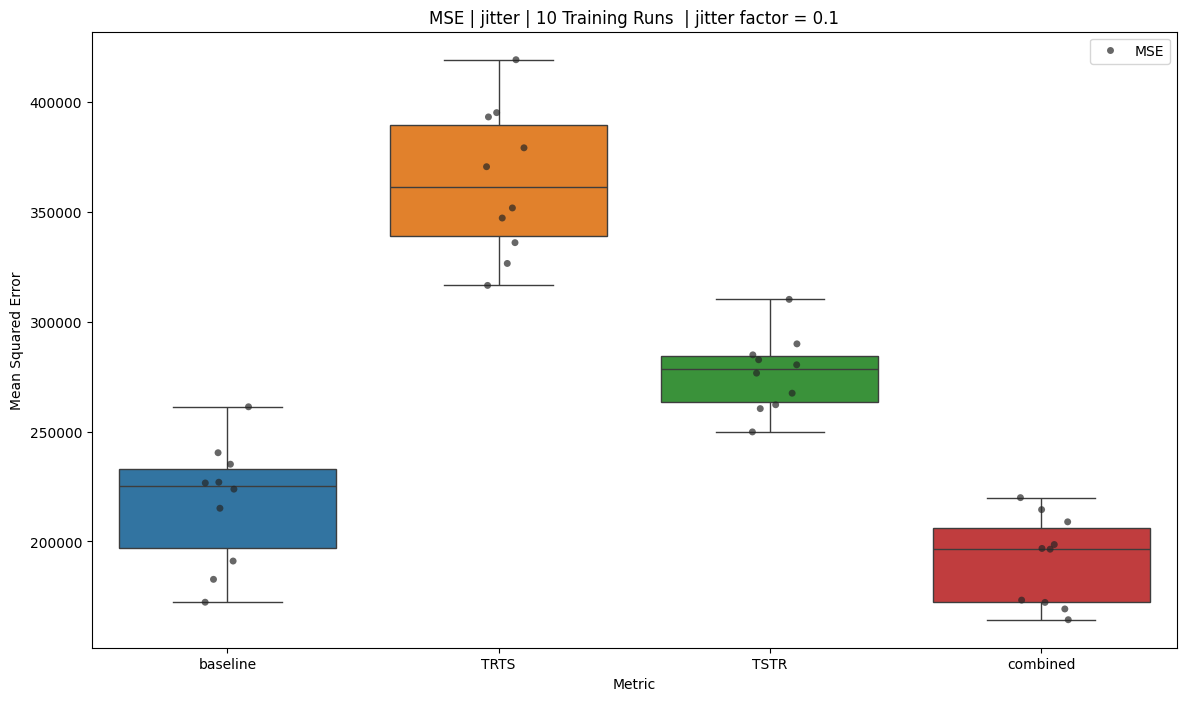

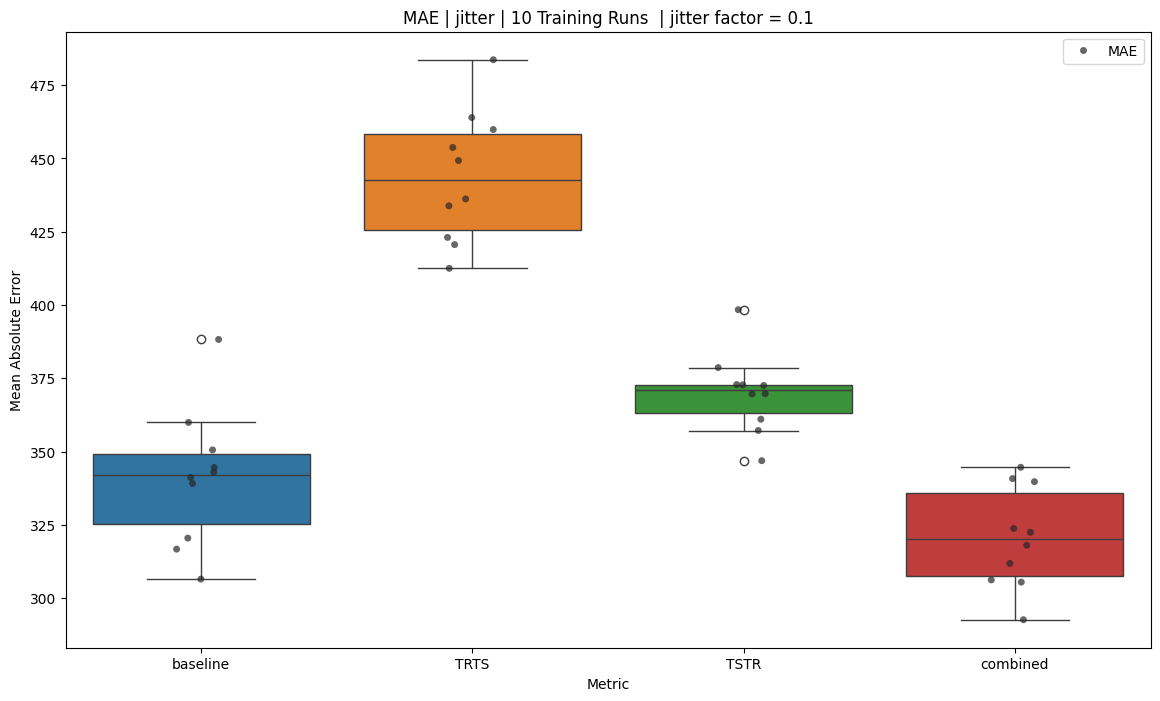

In [28]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

## 3 Evaluate Similarity of Synthetic vs Real Data

## 4 Visualize Synthetic vs Real Data

In [29]:
# split data before feeding into visual evaluation
data_real_seq = split_data_into_sequences(data_real_numpy, seq_len=hyperparameters['seq_len'], shuffle_data=True)

if data_syn_numpy.ndim == 3:
    data_syn_seq = data_syn_numpy
else:
    data_syn_seq = split_data_into_sequences(data_syn_numpy, seq_len=hyperparameters['seq_len'], shuffle_data=True)

Shape of the data after splitting into sequences: (28500, 12, 5)
Shape of the data after splitting into sequences: (28500, 12, 5)


Preprocessing data. Shape: (28500, 12, 5)
Data has been preprocessed. Shape: (1000, 60)


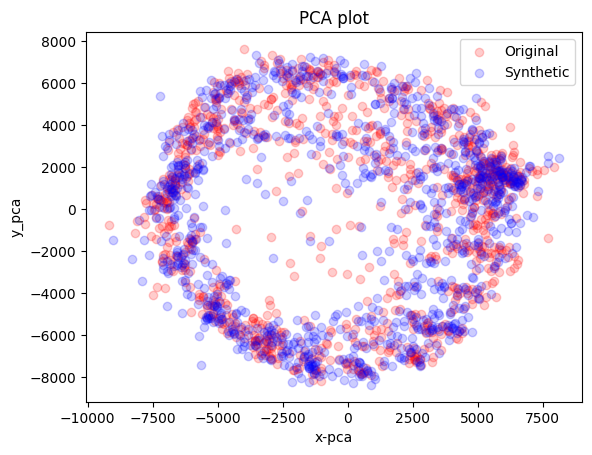

Preprocessing data. Shape: (28500, 12, 5)
Data has been preprocessed. Shape: (1000, 60)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000

c:\Users\fanny\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1082.942789
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.480503
[t-SNE] KL divergence after 300 iterations: 0.916692


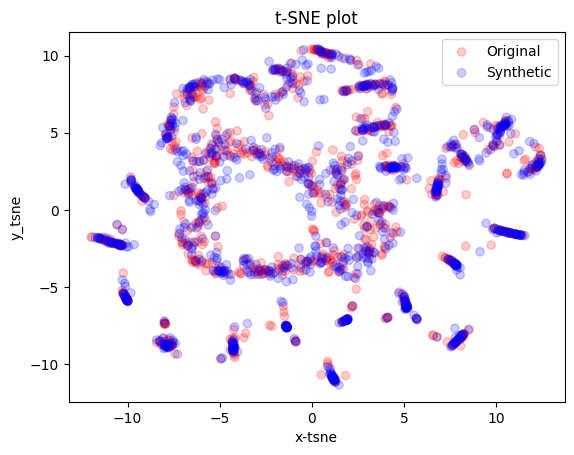

In [30]:
visualize(data_real_seq, data_syn_seq, metric='pca')
visualize(data_real_seq, data_syn_seq, metric='tsne')

### Beispielaussage:
PCA-Analyse von Realen und Synthetischen Daten
Um die Ähnlichkeit zwischen den realen und synthetischen Daten zu bewerten, wurde eine Principal Component Analysis (PCA) durchgeführt. Die PCA reduziert die Dimensionalität der Daten und projiziert sie auf eine zweidimensionale Ebene, wobei die Hauptkomponenten beibehalten werden, die den größten Teil der Varianz erklären.

Abbildung X zeigt den PCA-Plot der realen (rote Punkte) und synthetischen Daten (blaue Punkte). Die folgenden Beobachtungen können gemacht werden:

Verteilung und Clusterbildung:

Die roten Punkte, die die realen Daten repräsentieren, sind in einem spezifischen Bereich konzentriert.
Die blauen Punkte, die die synthetischen Daten darstellen, zeigen eine größere Verteilung und decken einen breiteren Bereich ab.
Ähnlichkeit und Unterschiede:

Die Tatsache, dass die synthetischen Daten eine größere Variabilität aufweisen, könnte darauf hinweisen, dass sie eine breitere Vielfalt an Mustern generieren.
Die Cluster der realen und synthetischen Daten überlappen sich teilweise, was darauf hindeutet, dass die synthetischen Daten einige der Eigenschaften der realen Daten gut nachahmen. Allerdings gibt es auch Bereiche, in denen die synthetischen Daten stark von den realen Daten abweichen, was auf Unterschiede in den zugrunde liegenden Verteilungen hinweist.
Schlussfolgerung:

Die PCA-Analyse zeigt, dass die synthetischen Daten in gewissem Maße die Struktur der realen Daten einfangen, jedoch eine größere Variabilität aufweisen.
Weitere Untersuchungen und Anpassungen am Generierungsprozess der synthetischen Daten könnten notwendig sein, um deren Genauigkeit und Übereinstimmung mit den realen Daten zu verbessern.